# Deteccion de Anomalias: Isolation Forest

Basado en arboles de decision permiten clasificar con conjuntos de datos desequilibrados.
Se aplica en este ejemplo al conjunto de datos de deteccion de transacciones fraudulentas y legitimas.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

## 1. Leer el conjunto

In [3]:
df = pd.read_csv("../datasets/creditcard.csv")

## 2. Visualizar el conjunto

In [4]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

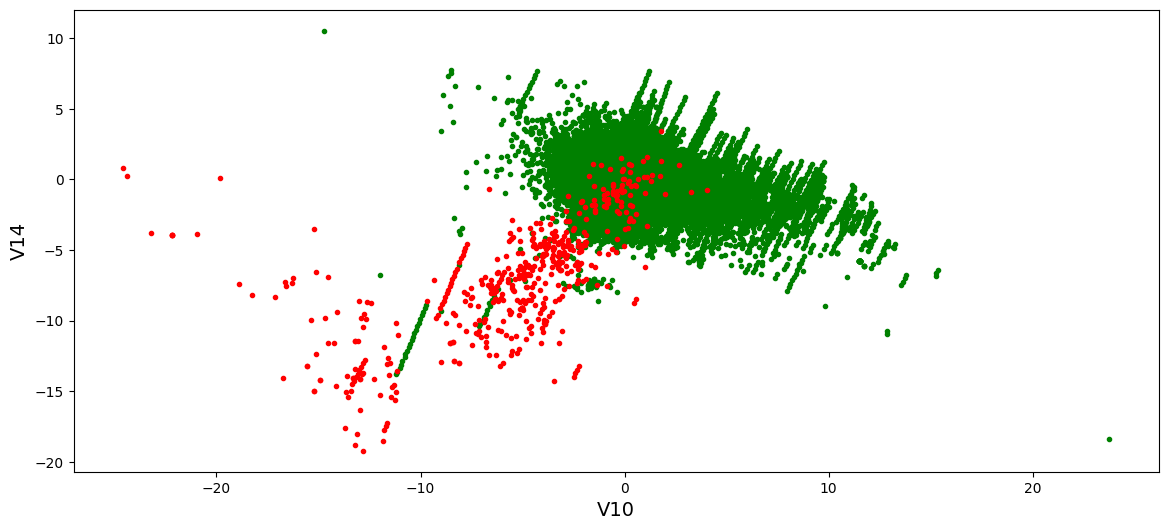

In [6]:
# Representación gráfica de dos características que diferencian las transacciones 
# fraudulentas de legitimas
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

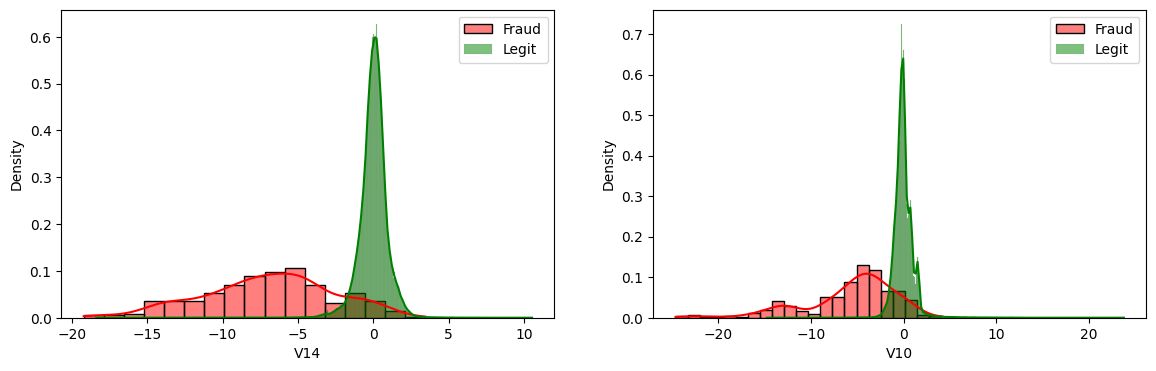

In [7]:
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 2)

# Representación de la característica 1
ax = plt.subplot(gs[0])
sns.histplot(data=df[df['Class'] == 1], x="V14", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V14", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

# Representación de la característica 2
ax = plt.subplot(gs[1])
sns.histplot(data=df[df['Class'] == 1], x="V10", kde=True, color="red", stat="density", label="Fraud", alpha=0.5)
sns.histplot(data=df[df['Class'] == 0], x="V10", kde=True, color="green", stat="density", label="Legit", alpha=0.5)
ax.legend()  # Para mostrar la leyenda

plt.show()

## 3. Preparar el conjunto

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [8]:
df_prep = df.drop(["Time", "Amount"], axis=1)

## 4. Isolation Forest con un conjunto de datos de dos dimensiones

In [9]:
X = df_prep.drop("Class", axis=1)
y = df_prep["Class"].copy()

In [10]:
X_reduced = X[["V10", "V14"]].copy()

In [31]:
# Entrenar el modelo
from sklearn.ensemble import IsolationForest

model_iforest = IsolationForest(contamination=0.01, max_samples=300)
model_iforest.fit(X_reduced)

IsolationForest(contamination=0.01, max_samples=300)

/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


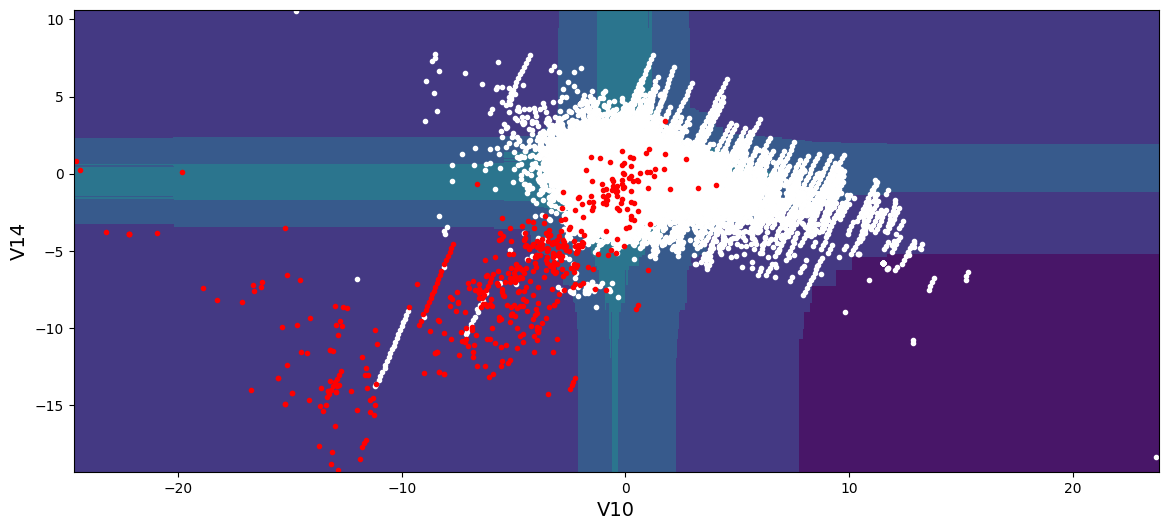

In [32]:
# Representar el limite de decision
def plot_isolation_forest(X, y, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = model_iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'w.')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.')
    
plt.figure(figsize=(14, 6))
plot_isolation_forest(X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [33]:
# Identificar anomalias
anomalies = model_iforest.predict(X_reduced)

/home/ljmor/anaconda3/envs/curso_deep_learning/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


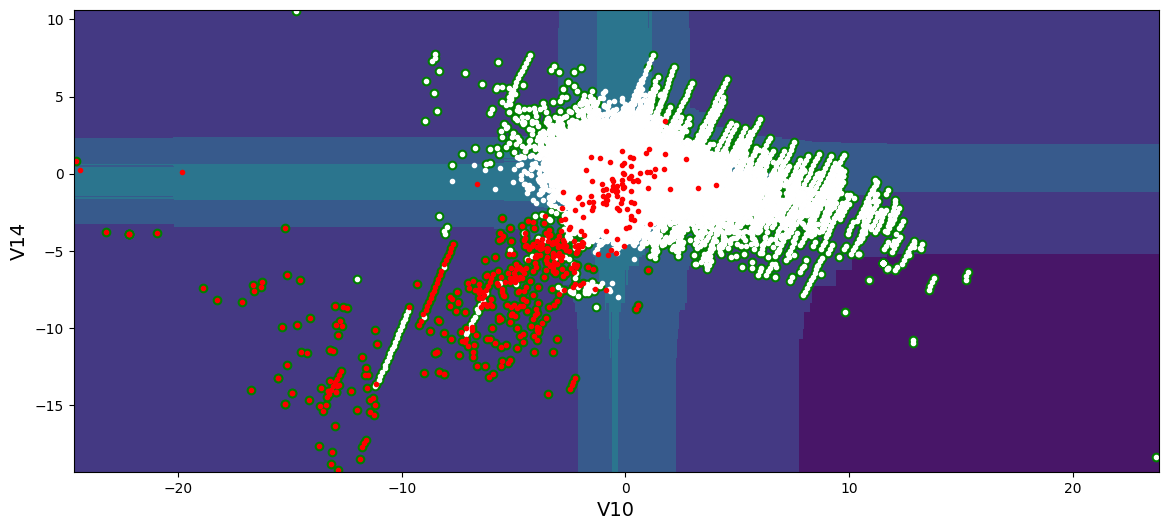

In [34]:
# Representación gráfica de las anomalías
plt.figure(figsize=(14, 6))
plt.plot(X_reduced["V10"][anomalies == -1], X_reduced["V14"][anomalies == -1], 'go', markersize=6)
plot_isolation_forest(X_reduced.values, y)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [35]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 2849


In [36]:
# Verdaderos y falsos positivos de casos fraudulentos en el total de anomalías
y[anomalies==-1].value_counts()

Class
0    2449
1     400
Name: count, dtype: int64

Detecto de 492 anomalos 400 y los falsos positivos 2449 de 284.315 que en realidad eran legitimos

## 5. Isolation Forest con un conjunto de datos multidimensional

In [18]:
# Entrenamiento del modelo
model_iforest = IsolationForest(max_samples=100, contamination=0.015)
model_iforest.fit(X)

IsolationForest(contamination=0.015, max_samples=100)

In [19]:
# Identificación de anomalías
anomalies = model_iforest.predict(X)

In [20]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 4273


In [21]:
# Verdaderos y falsos positivos de casos fraudulentos
y[anomalies==-1].value_counts()

Class
0    3931
1     342
Name: count, dtype: int64

Detecto de 492 anomalos 342 y los falsos positivos 3931 de 284.315 que en realidad eran legitimos

## 6. Busqueda del mejor parametro de contaminacion

In [22]:
# Creamos nuestro propio estimador para que la salida del algoritmo este comprendida entre 0 y 1
from sklearn.base import BaseEstimator

class IsolationForestCustom(BaseEstimator):
    def __init__(self, max_samples=100, contamination=0.1):
        self.contamination = contamination
        self.max_samples = max_samples
        self._ift_clf = None
        
    def fit(self, X, y=None):
        self._ift_clf = IsolationForest(max_samples=self.max_samples, 
                                        contamination=self.contamination)
        self._ift_clf.fit(X) 
        return self
    
    def predict(self, X, y=None):
        preds = self._ift_clf.predict(X)
        preds[preds==1] = 0
        preds[preds==-1] = 1
        return preds
    
    def get_params(self, deep=True):
        return {"contamination": self.contamination,
               "max_samples": self.max_samples}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_samples': [100, 200, 300], 'contamination': [0.001, 0.01, 0.1]}

model_iforest = IsolationForestCustom()

# train across 5 folds, that's a total of 6*2=12 rounds of training 
grid_search = GridSearchCV(model_iforest, param_grid, cv=2,
                           scoring='f1', return_train_score=True)

grid_search.fit(X_reduced, y)

GridSearchCV(cv=2, estimator=IsolationForestCustom(),
             param_grid={'contamination': [0.001, 0.01, 0.1],
                         'max_samples': [100, 200, 300]},
             return_train_score=True, scoring='f1')

In [24]:
grid_search.best_estimator_

IsolationForestCustom(contamination=0.001, max_samples=300)

El modelo con los mejores parametros sera aquel con una contaminancion de 0.001 y max_samples de 300